# Сейсмическая задача

## Подготовка

GeologyIO\` и GPNTools\` разработаны специально для компании Газпром Нефть НТЦ
**Обращаться к Екименко Антону**

In [17]:
$HistoryLength = 0;
Get["GeologyIO`"]
Get["GPNTools`"]

## Импорт данных

Сам импорт

In [20]:
trainTable = 
Normal[Import["Heff+NTG_train.xlsx", "Dataset", "HeaderLines" -> 1][[1]]];

In [21]:
testTable = 
Normal[Import["Heff+NTG_train.xlsx", "Dataset", "HeaderLines" -> 1][[2]]];

In [22]:
horiz = Function[arr, <|
    "toCoord" -> Dispatch[Round[#[[{1, 2}]]] -> 
            #[[{3, 4, 5}]]& /@ arr[[All, {3, 6, 7, 8, 9}]]], 
    "toIndex" -> Dispatch[Round[#[[{3, 4}]]] -> 
            #[[{1, 2}]]& /@ arr[[All, {3, 6, 7, 8, 9}]]]
|>] @ 
Import["seismic_interpretation_new.charisma"]; 

In [23]:
cube = SEGYImport["3D_cube_new.sgy", "Loading" -> "Delayed"];

Таблицы


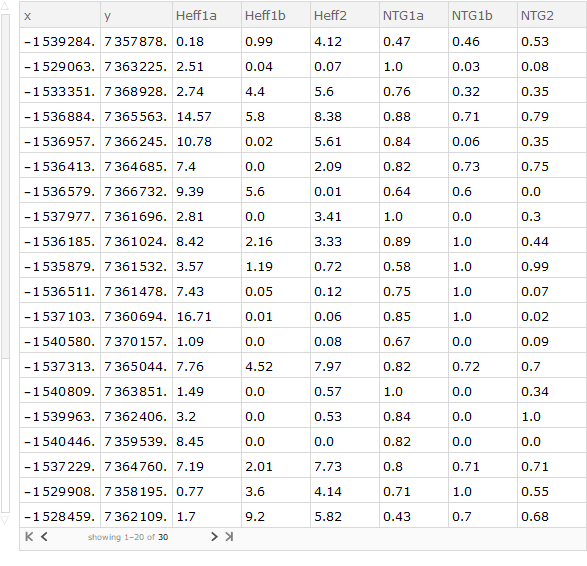

In [25]:
StandardForm[Dataset[trainTable]]


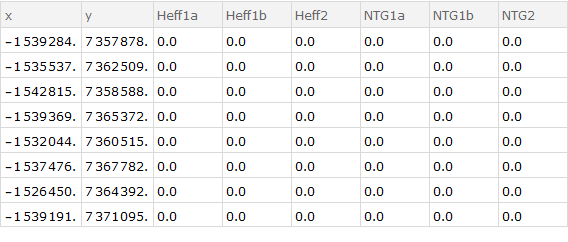

In [26]:
StandardForm[Dataset[testTable]]

3D-карта глубин


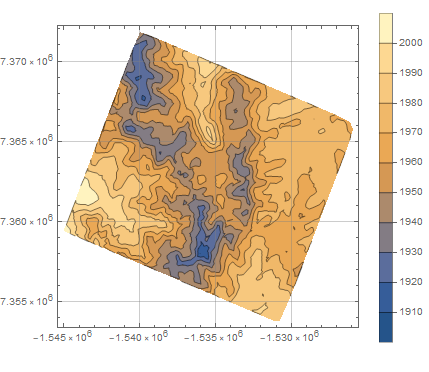

In [27]:
ListContourPlot[Values[Normal[horiz["toCoord"]][[1 ;; -1 ;; 100]]], 
    ImageSize -> Medium, 
    GridLines -> Automatic, 
    PlotLegends -> Automatic
]

Срез куба


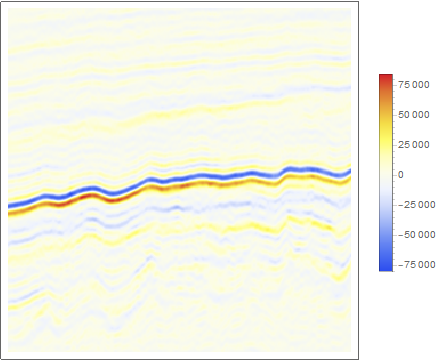

In [28]:
ArrayPlot[
	Transpose[SEGYLoad[cube["TracesUnloaded", 1 ;; 
		cube["BinaryHeader", "NumberOfSamplesForReel"]]]], 
	ColorFunction -> "TemperatureMap", 
	ImageSize -> Medium, PlotLegends -> Automatic
]

## Приведение данных

У нас есть координаты из тестовых данных. 
По этим координатам необходимо взять трассы. 
К сожалению координаты трасс и скважин не совпадают точно. 
Придется ради экономии написать "неадекватный" код:

In [29]:
Options[WellTraces] = {"count" -> 1};

In [40]:
WellTraces[cube_SEGYData, horiz_Association, table_List, OptionsPattern[]] := 
Block[{$indexes, $traceIndex,  
    $ilineMin, $ilineMax, $xlineMin, $xlineMax, $ilineLen, $xlineLen, 
    $count = OptionValue["count"], 
    $delrt = ("delrt" /. SEGYLoad[cube["traceheadersunloaded", 1]]) / 1000.0, 
    $dt = ("dt" /. SEGYLoad[cube["traceheadersunloaded", 1]]) / 1000000.0, 
    $ns = "ns" /. SEGYLoad[cube["traceheadersunloaded", 1]]
}, 
    $indexes = Flatten[Table[
        Select[(g + #& /@ SortBy[Tuples[Range[-100, 100], 2], Abs /* Total]) /. 
        horiz["toIndex"], Total[Abs[#]] < 10000&][[1 ;; $count]], 
        {g, Round[Normal[Query[All, {"x", "y"} /* Values] @ table]]}
    ], 1];  
    {$ilineMin, $ilineMax} = "iline" /. 
        SEGYLoad[cube["TraceHeadersUnloaded", {1, -1}]]; 
    {$xlineMin, $xlineMax} = "xline" /. 
        SEGYLoad[cube["TraceHeadersUnloaded", {1, -1}]]; 
    $ilineLen = $ilineMax - $ilineMin + 1; 
    $xlineLen = $xlineMax - $xlineMin + 1; 
    $traceIndex[{iline_Integer, xline_Integer}] := 
        (iline - $ilineMin) * $xlineLen + xline - $xlineMin + 1; 
    
    MapThread[
        Association[Append[
            Thread[{"x", "y", "t"} -> #1 / {1, 1, 1000.0}], 
            "trace" -> TimeSeries[#2, 
                {Range[$delrt, $delrt + $ns * $dt - $dt, $dt]}]
        ]]&, 
        {
            $indexes /. horiz["toCoord"], 
            SEGYLoad[cube["tracesunloaded", $traceIndex /@ $indexes]]
        }
    ]
]

Выберем по одной ближайшей трассе около точек из тестовой таблицы:


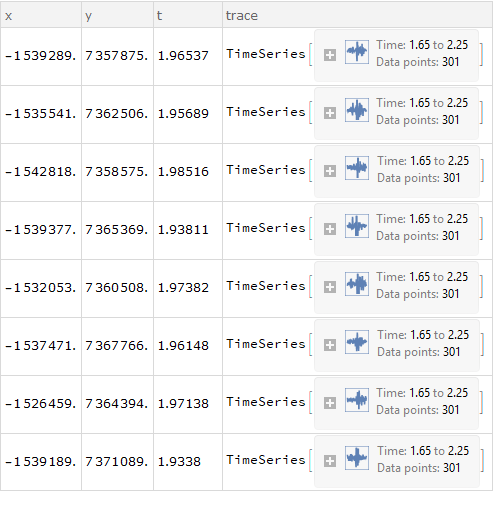

In [31]:
StandardForm[Dataset[WellTraces[cube, horiz, testTable, "count" -> 1]]]

## Интерполяция таблицы

Трассы находятся не точно в скважинах. Если у нас 4 близкие трассы - 
то есть проблема выбора значений для них. 
Попробуем просто использовать IDW на таблице:


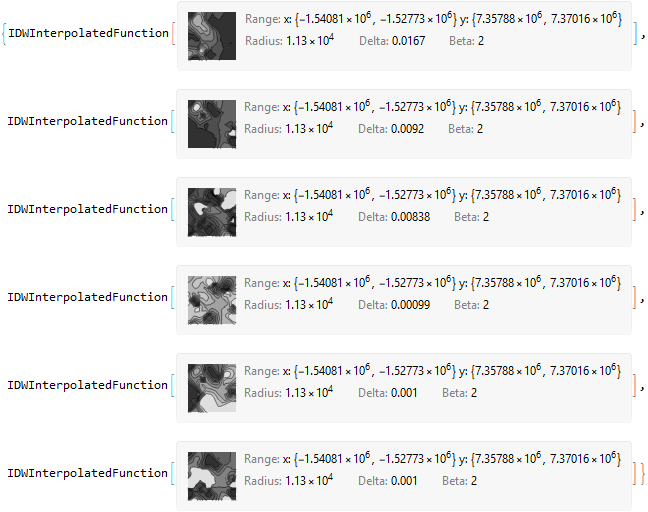

In [32]:
Table[
    trainValues[column] = 
    IDWInterpolation[Values[trainTable[[All, {"x", "y", column}]]]], 
    {column, {"Heff1a", "Heff1b", "Heff2", "NTG1a", "NTG1b", "NTG2"}}
]

Теперь даже если координата трассы не совпадает точно 
с координатой известного значения из таблицы, 
то все равно можно вычислить приближенно значения толщин. 
Однако стоит помнить, что для малого числа точек это 
работает только вбизи известных значений

In [33]:
trainTable[[1, "Heff1a"]]
trainValues["Heff1a"][Values[trainTable[[1, {"x", "y"}]]] + {100, 100}]

Out[33]:
 
 
 0.18 
 
 Out[34]:
 
 
 0.180286

## Функции

Здесь стоит определять все вспомогательные функции

Получение куска временного ряда

In [35]:
traceWindow[{t1_?NumericQ, t2_?NumericQ}] := 
Function[a, TimeSeriesWindow[a["trace"], a["t"] + {t1, t2}]]

In [38]:
traceWindow[dt_?NumericQ] := 
traceWindow[{-dt, dt} / 2]

Разложение трассы на компоненты

In [41]:
waveleComponent[n_Integer][ts_] := 
TimeSeries[
    Re[ContinuousWaveletTransform[ts["Values"], 
    MexicanHatWavelet[]][[1, n]]], {ts["Times"]}
]

Это специальное определение для вырезки окна

In [42]:
waveleComponent[n_Integer][a_Association] := 
<|"t" -> a["t"], "trace" -> waveleComponent[n][a["trace"]]|>

Поиск ближайшего минимума слева/справа

In [44]:
nearMin["left"][a_Association] := 
Block[{
    $w = traceWindow[{a["trace"]["FirstTime"]-a["t"], 0}][a]["Path"], 
    $tmin = 0
}, 
    Print[$w];
    Table[
        If[$tmin === 0 && $w[[-i, 2]] <= 
        $w[[-i + 1, 2]] && $w[[-i, 2]] < $w[[-i - 1, 2]], 
            $tmin = $w[[i, 1]]
        ], 
        {i, 2, Length[$w] - 1}
    ]; $tmin
]

In [45]:
nearMin["right"][a_Association] := 
Block[{
    $w = traceWindow[{0, a["trace"]["LastTime"]-a["t"]}][a]["Path"], 
    $tmin = 0
}, 
    Print[$w];
    Table[
        If[$tmin === 0 && $w[[i, 2]] <= 
        $w[[i + 1, 2]] && $w[[i, 2]] < $w[[i - 1, 2]], 
            $tmin = $w[[i, 1]]
        ], 
        {i, 2, Length[$w] - 1}
    ]; $tmin
]

## Создание таблицы с атрибутами

In [46]:
DataQuery = Query[All, <|
    "x" -> "x", 
    "y" -> "y", 
    "t" -> "t", 
    
    "trace" -> "trace",
    
    "window" -> {"t", "trace"} /* 
        traceWindow[{0, 0.03}], 

    "windowImg" -> {"t", "trace"} /* 
        traceWindow[{0, 0.03}] /* DateListPlot, 

    "RMS(0ms)" -> {"t", "trace"} /* 
        traceWindow[{0.00,0.01}] /* RootMeanSquare,

    "RMS(10ms)" -> {"t", "trace"} /* 
        traceWindow[{0.01,0.02}] /* RootMeanSquare,

    "RMS(20ms)" -> {"t", "trace"} /* 
        traceWindow[{0.020,0.03}] /* RootMeanSquare,

    "RMS(0mscwt8)" -> {"t", "trace"} /* 
        waveleComponent[8] /* traceWindow[{0.00,0.01}] /* RootMeanSquare,

    "RMS(0mscwt16)" -> {"t", "trace"} /* 
        waveleComponent[16] /* traceWindow[{0.00,0.01}] /* RootMeanSquare, 

    "RMS(0mscwt20)" -> {"t", "trace"} /* 
        waveleComponent[20] /* traceWindow[{0.00,0.01}] /* RootMeanSquare, 

    "RMS(10mscwt8)" -> {"t", "trace"} /* 
        waveleComponent[8] /* traceWindow[{0.01,0.02}] /* RootMeanSquare, 

    "RMS(10mscwt16)" -> {"t", "trace"} /* 
        waveleComponent[16] /* traceWindow[{0.01,0.02}] /* RootMeanSquare, 

    "RMS(10mscwt20)" -> {"t", "trace"} /* 
        waveleComponent[20] /* traceWindow[{0.01,0.02}] /* RootMeanSquare, 

    "RMS(20mscwt8)" -> {"t", "trace"} /* 
        waveleComponent[8] /* traceWindow[{0.02,0.03}] /* RootMeanSquare, 

    "RMS(20mscwt16)" -> {"t", "trace"} /* 
        waveleComponent[16] /* traceWindow[{0.02,0.03}] /* RootMeanSquare, 

    "RMS(20mscwt20)" -> {"t", "trace"} /* 
        waveleComponent[20] /* traceWindow[{0.02,0.03}] /* RootMeanSquare, 


    "Heff1a" -> {"x", "y"} /* Values /* 
        trainValues["Heff1a"] /* (# * (1 + RandomReal[{-0.025, 0.025}])&), 

    "Heff1b" -> {"x", "y"} /* Values /* 
        trainValues["Heff1b"] /* (# * (1 + RandomReal[{-0.025, 0.025}])&), 

    "Heff2" -> {"x", "y"} /* Values /* 
        trainValues["Heff2"] /* (# * (1 + RandomReal[{-0.025, 0.025}])&), 

    "NTG1a" -> {"x", "y"} /* Values /* trainValues["NTG1a"] /* 
        (# * (1 + RandomReal[{-0.025, 0.025}])&), 

    "NTG1b" -> {"x", "y"} /* Values /* 
        trainValues["NTG1b"] /* (# * (1 + RandomReal[{-0.025, 0.025}])&), 

    "NTG2" -> {"x", "y"} /* Values /* trainValues["NTG2"] /* 
        (# * (1 + RandomReal[{-0.025, 0.025}])&)
|>]; 

Выбор по 6 трасс около каждой скважины для тренировки

In [47]:
trainTraces = WellTraces[cube, horiz, trainTable, "count" -> 6];

Таблица с данным для тренировки


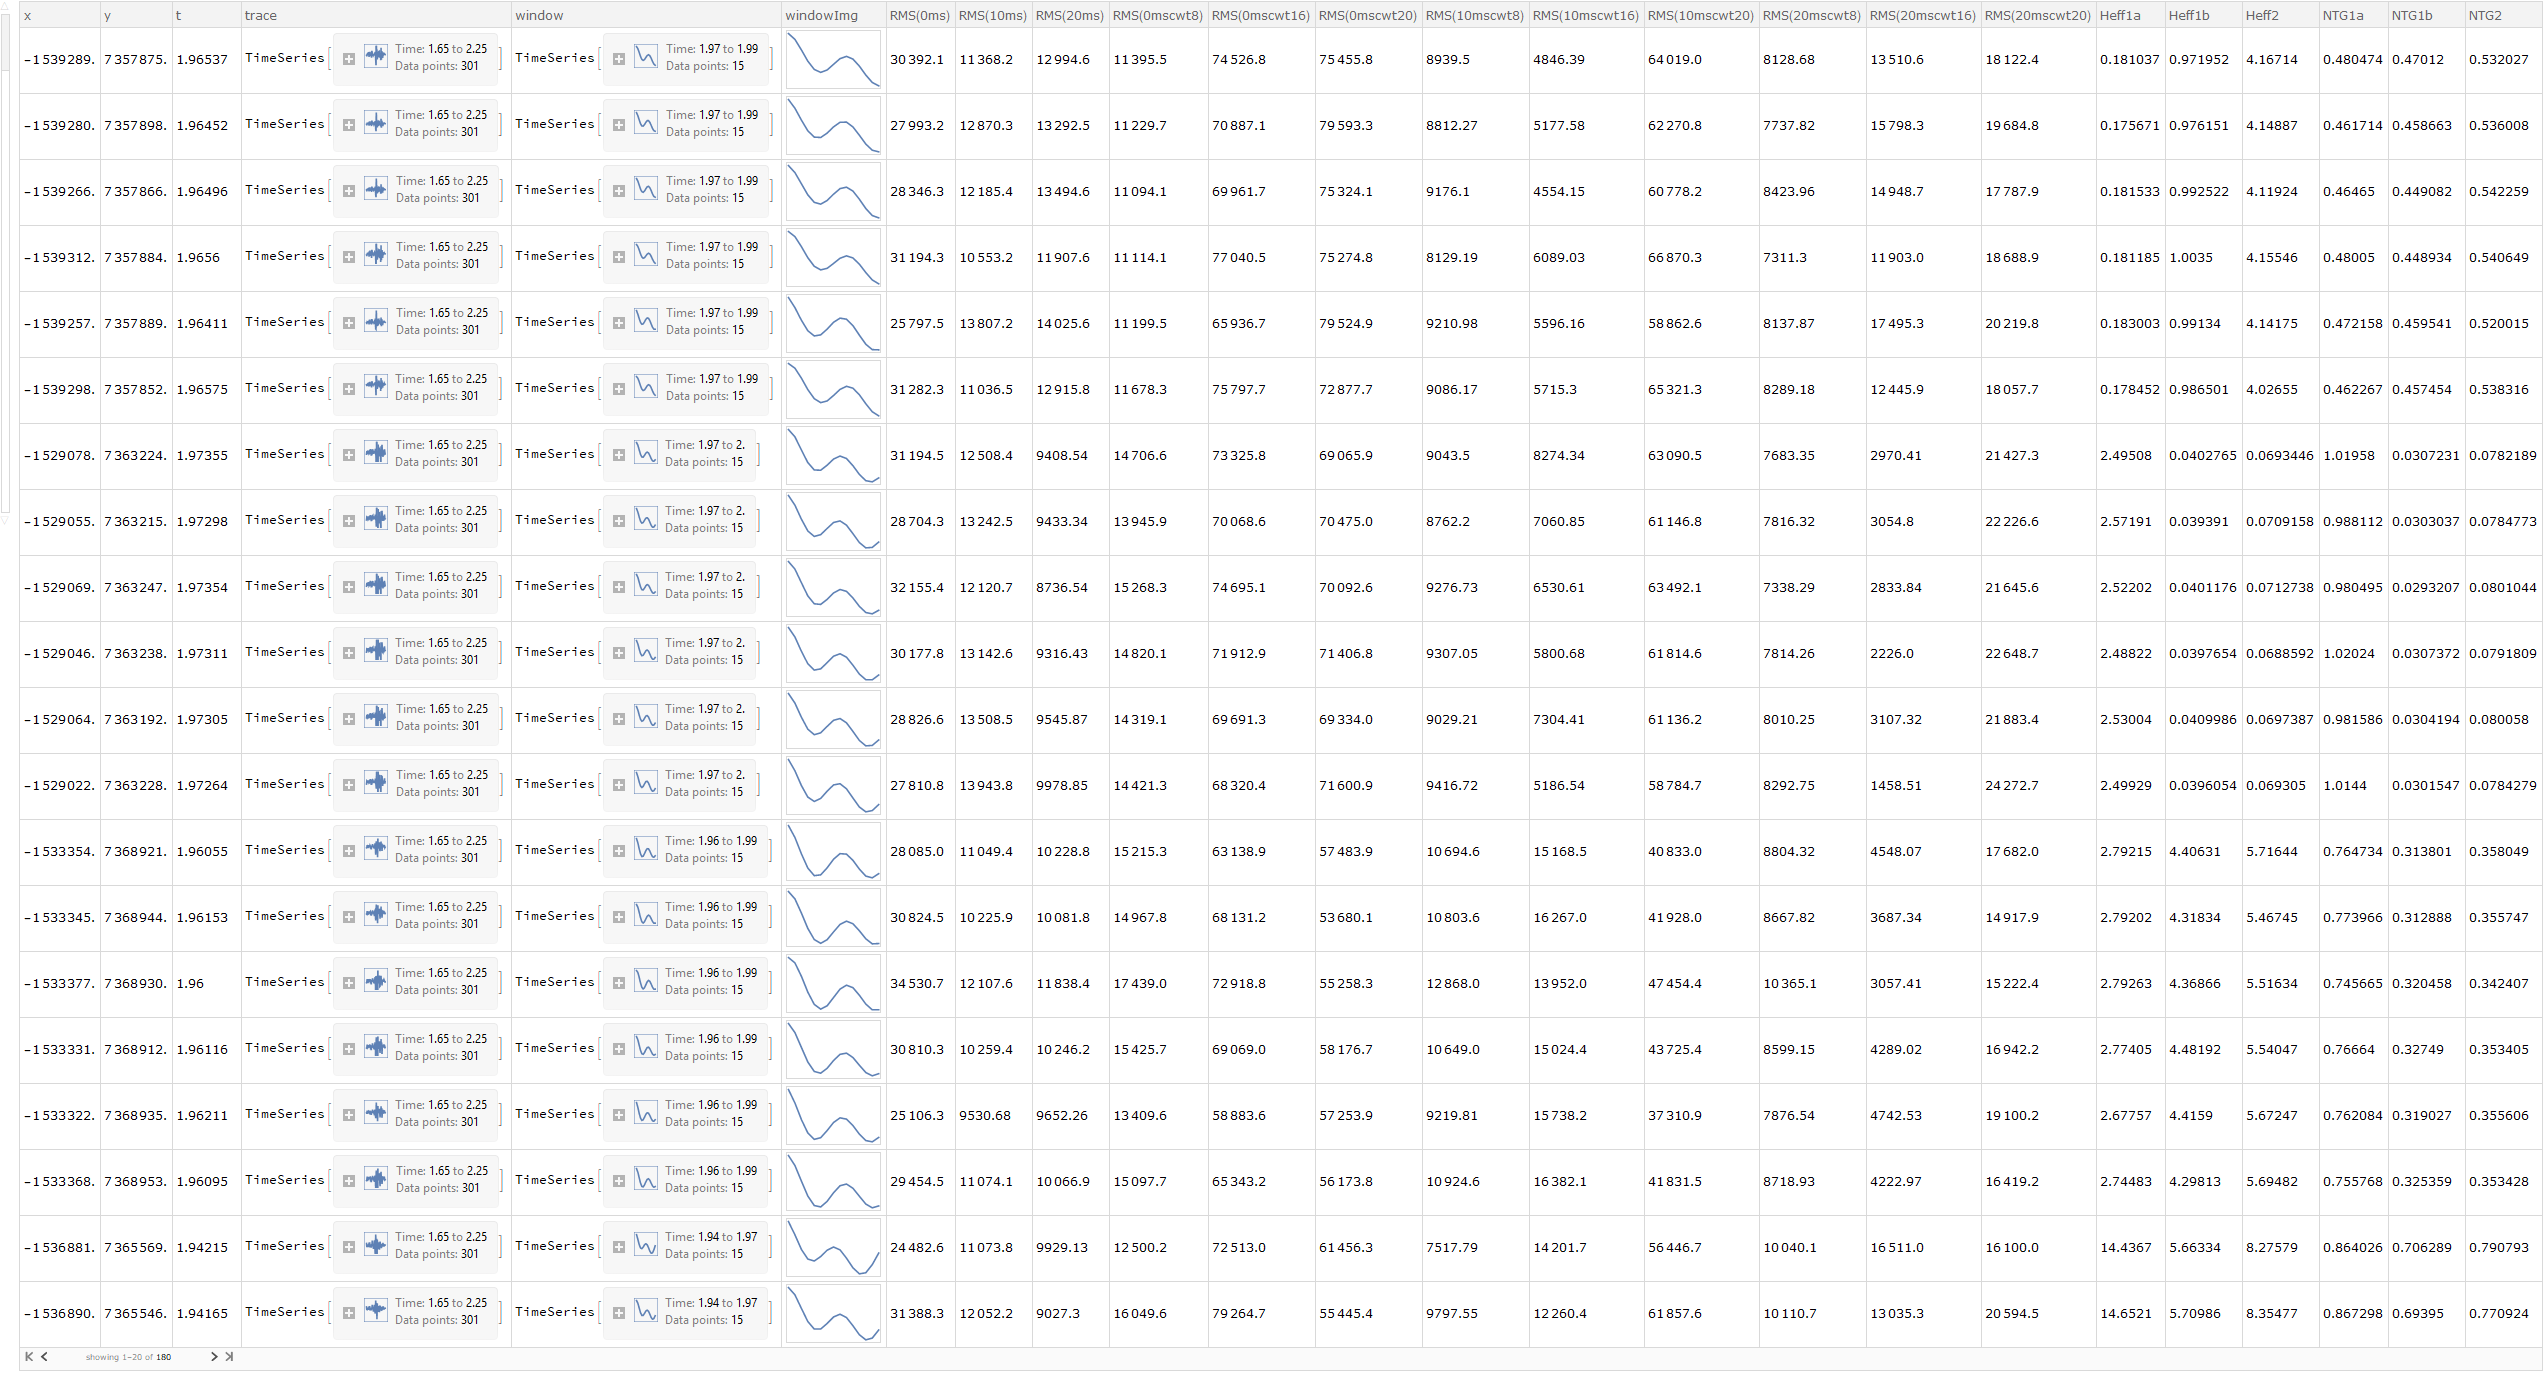

In [48]:
StandardForm[Dataset[trainDataset = DataQuery @ trainTraces]]

## Тренировка

Специальная функция для тестирование обчения

In [49]:
checkPredictor[data_List, attrs: {__String}, key_String, {n_Integer, m_Integer}, method_String] := 
Block[{$trainDataTest, $trainSample, $trainCheck, $predictorTest, 
    $data = Query[All, Append[attrs, key]] @ data}, 
    Table[
        $trainSample = RandomSample[$data, n];
        $trainCheck = Complement[$data, $trainSample];
        Clear[$predictorTest]; 
        $predictorTest = Predict[$trainSample -> key, Method -> method];
        Transpose[{$trainCheck[[All, key]], $predictorTest[$trainCheck]}], 
        {m}
    ]
]

Список атрибутов на котором будет производиться обучение

In [50]:
trainAttrs = {"t", 
    "RMS(0ms)", "RMS(10ms)", "RMS(20ms)", 
    "RMS(0mscwt8)", "RMS(0mscwt16)", "RMS(0mscwt20)", 
    "RMS(10mscwt8)", "RMS(10mscwt16)", "RMS(10mscwt20)", 
    "RMS(20mscwt8)", "RMS(20mscwt16)", "RMS(20mscwt20)"
}; 

Тренировка на случайной выборке 25/30 трасс  
Нейросеть восстанавливает данные 5 раз на разных выборках

In [ ]:
checkRes = Association[Table[
    key -> 
    checkPredictor[trainDataset[[1 ;; -1 ;; 6]], trainAttrs, key, {25, 5}, 
        "NeuralNetwork"], 
    {key, {"Heff1a", "Heff1b", "Heff2", "NTG1a", "NTG1b", "NTG2"}}
]]; 

Построим результат


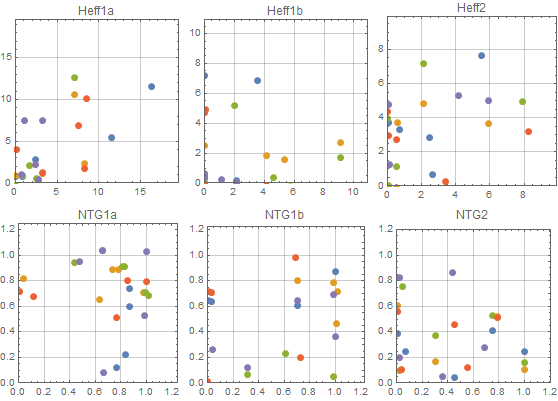

In [53]:
Grid[ArrayReshape[Table[ListPlot[checkRes[key], 
    ImageSize -> Small, 
    Frame -> True, 
    PlotRange -> {{0, 1.2Max[Flatten[checkRes[key]]]}, 
        {0, 1.2Max[MinMax[Flatten[checkRes[key]]]]}}, 
    GridLines -> Automatic, 
    AspectRatio -> 1, 
    PlotStyle -> PointSize[Large], 
    PlotLabel -> key
], {key, Keys[checkRes]}], {2, 3}]]

Посмотрим на корреляцию каждой выборки


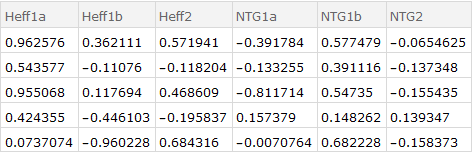

In [54]:
StandardForm[Dataset[Map[Association, 
    Transpose[Map[Thread, Normal[Map[Transpose /* 
    Apply[Correlation]] /@ checkRes]]]
]]]

Теперь все тоже самое, но выберем побольше трасс

In [ ]:
checkRes2 = Association[Table[
    key -> 
    checkPredictor[trainDataset[[1 ;; -1 ;; 2]], trainAttrs, key, 
        {60, 5}, "NeuralNetwork"], 
    {key, {"Heff1a", "Heff1b", "Heff2", "NTG1a", "NTG1b", "NTG2"}}
]]; 

Картинки


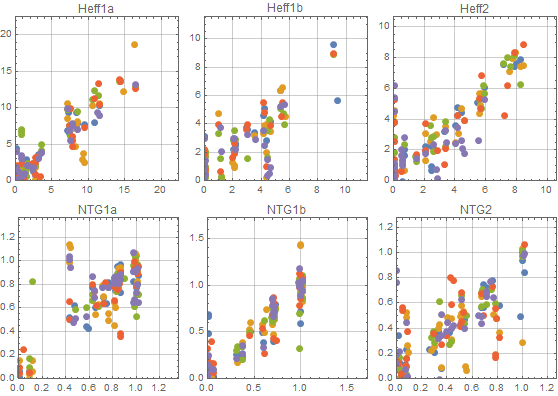

In [56]:
Grid[ArrayReshape[Table[ListPlot[checkRes2[key], 
    ImageSize -> Small, 
    Frame -> True, 
    PlotRange -> {{0, 1.2Max[Flatten[checkRes2[key]]]}, 
        {0, 1.2Max[MinMax[Flatten[checkRes2[key]]]]}}, 
    GridLines -> Automatic, 
    AspectRatio -> 1, 
    PlotStyle -> PointSize[Large], 
    PlotLabel -> key
], {key, Keys[checkRes2]}], {2, 3}]]

Местами невероятная корреляция


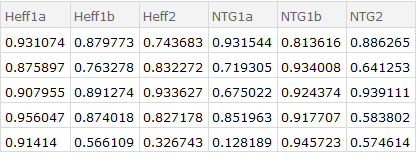

In [58]:
StandardForm[Dataset[Map[Association, Transpose[Map[Thread, 
Normal[Map[Transpose /* Apply[Correlation]] /@ checkRes2]]]]]]

Что ж... 
Попробуем натренировать сеть...

In [ ]:
ClearAll[predictors];
predictors = Association[Table[key -> 
    Predict[trainDataset[[All, Append[trainAttrs, key]]] -> key, 
        Method -> "NeuralNetwork"], 
{key, {"Heff1a", "Heff1b", "Heff2", "NTG1a", "NTG1b", "NTG2"}}]]

... и применить к тестовым данным:


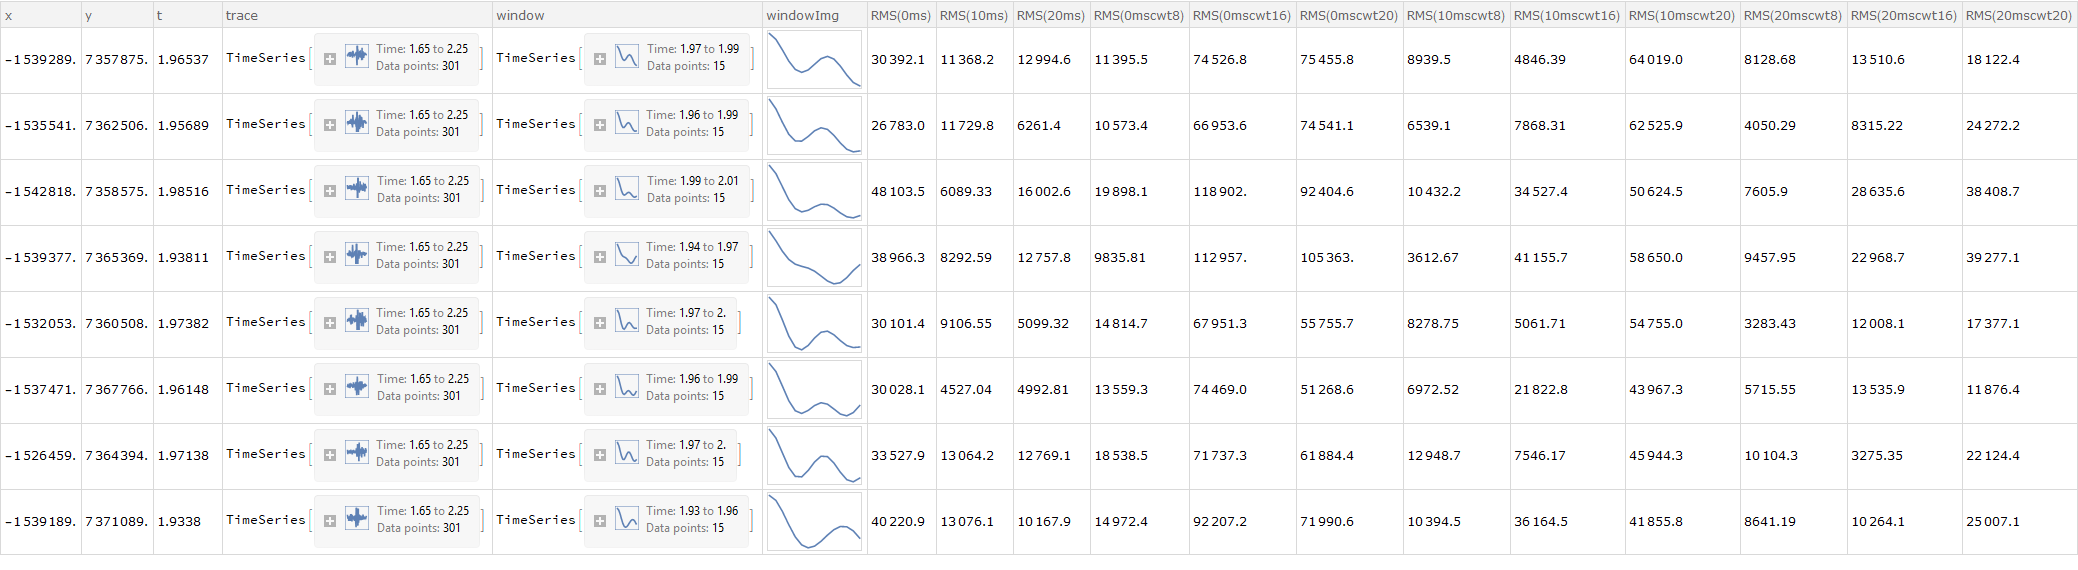

In [61]:
StandardForm[Dataset[testDataset = 
Query[All, 1 ;; -7] @ DataQuery @ WellTraces[cube, horiz, testTable]]]

**Результат**


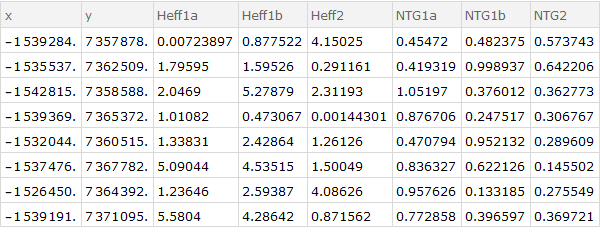

In [63]:
StandardForm[Dataset[result = MapThread[
    Association[Join[#1, #2]]&, {
        Normal[testTable[[All, {"x", "y"}]]], 
        Transpose[Table[Thread[key -> 
            predictors[key][testDataset]], {key, Keys[predictors]}]]
    }
]]]

**Ответ**


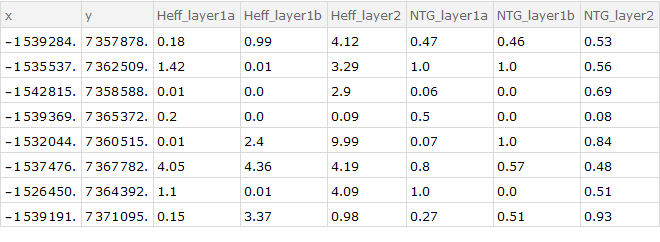

In [64]:
StandardForm[Dataset[answer = 
Normal[First[Import["Heff+NTG_test_answer.xlsx", 
    "Dataset", "HeaderLines" -> 1]]]]]

**Ошибка**

In [65]:
Total[MapThread[
    Total[((#1 - #2))^2] / Length[#1]&, 
    {
        Values[answer[[All, 3 ;; 5]]], 
        Values[result[[All, 3 ;; 5]]]
    }]] / Length[answer]

7.01162

И сохраним результат

In [66]:
Export["Heff+NTG_test_result.xlsx", Dataset[result]]

Heff+NTG_test_result.xlsx